In [19]:
import numpy as np
import matplotlib.pyplot as plt
from disba import PhaseDispersion, depthplot
from scipy.optimize import least_squares

# Reproducibility for synthetic noise
np.random.seed(42)

In [20]:
# Synthetic dispersion data generation

velocity_model = np.array([
    [40.0, 1000.0,  500.0, 2000.0],
    [ 0.0, 2000.0, 1000.0, 2000.0],
]) * 1.0e-3  # convert from (m, m/s, m/s, kg/m^3) to (km, km/s, km/s, g/cc)-like scale

# Thickness array for plotting (use a dummy last layer thickness for depthplot)
thk_true = np.append(velocity_model[:-1, 0].copy(), 1.0)
vs_true  = velocity_model[:, 2].copy()

# Period sampling (s)
# Here we create frequencies 3~10 Hz and convert to periods (reversed)
f = np.linspace(3.0, 10.0, 20)     # Hz
periods = 1.0 / f[::-1]            # s (ascending)

pd = PhaseDispersion(*velocity_model.T)
cpr = pd(periods, mode=0, wave="rayleigh")

syn_period = cpr.period
syn_velocity = cpr.velocity + 0.01 * np.random.randn(len(cpr.velocity))  # add noise

In [21]:
def para2model(parameters):
    """
    Convert parameter vector to a layered model matrix for disba.

    parameters = [thk(n-1), vs(n)]
    returns model with columns: [thk(n), vp(n), vs(n), rho(n)]
    """
    parameters = np.asarray(parameters, dtype=float)
    n_layers = (len(parameters) + 1) // 2

    thk = parameters[:n_layers - 1].copy()     # (n-1,)
    vs  = parameters[n_layers - 1:].copy()     # (n,)

    vp = vs * 2.0                              # simple assumption: Vp = 2*Vs
    rho = np.full(n_layers, 2.0, dtype=float)  # constant density as an array (n,)

    # disba expects thickness per layer; last layer thickness = 0 for half-space
    thk_full = np.append(thk, 0.0)

    return np.column_stack((thk_full, vp, vs, rho))


def forward_disp(parameters, periods, mode=0):
    """
    Predict Rayleigh phase velocity at given periods using disba.
    """
    model = para2model(parameters)
    pd = PhaseDispersion(*model.T)
    cpr = pd(periods, mode=mode, wave="rayleigh")

    # Ensure output matches the given periods order
    return np.interp(periods, cpr.period, cpr.velocity)


def misfit_residual(parameters, observed_periods, observed_velocity, mode=0):
    """
    Least-squares residual vector (1D) required by scipy.optimize.least_squares.
    """
    pred = forward_disp(parameters, observed_periods, mode=mode)
    return observed_velocity - pred


def params2_thk_vs(parameters, last_thk_for_plot=1.0):
    """
    Parse parameters = [thk(n-1), vs(n)] into arrays for depthplot.
    """
    parameters = np.asarray(parameters, dtype=float)
    n_layers = (len(parameters) + 1) // 2

    thk = parameters[:n_layers - 1].copy()
    vs  = parameters[n_layers - 1:].copy()

    thk_plot = np.append(thk, last_thk_for_plot)
    return thk_plot, vs

def invert_dispersion_ls(
    observed_periods,
    observed_velocity,
    mode,
    x0,
    n_layers,
    thk_bounds=(0.001, 1.0),   # km
    vs_bounds=(0.05,  2.5),    # km/s
    method="trf",
    verbose=1,
    max_nfev=2000,
):
    """
    Least-squares inversion for Rayleigh dispersion.

    x0: initial parameter vector [thk(n-1), vs(n)]
    n_layers: number of layers (= len(vs))
    """
    x0 = np.asarray(x0, dtype=float)
    assert len(x0) == (n_layers - 1) + n_layers

    fun = lambda p: misfit_residual(p, observed_periods, observed_velocity, mode=mode)

    if method.lower() == "lm":
        # LM does NOT support bounds
        res = least_squares(
            fun, x0=x0,
            method="lm",
            verbose=verbose,
            max_nfev=max_nfev,
            x_scale="jac",
        )
    else:
        # Build bounds arrays for TRF / dogbox
        thk_lb = np.full(n_layers - 1, thk_bounds[0], dtype=float)
        thk_ub = np.full(n_layers - 1, thk_bounds[1], dtype=float)
        vs_lb  = np.full(n_layers,     vs_bounds[0],  dtype=float)
        vs_ub  = np.full(n_layers,     vs_bounds[1],  dtype=float)

        lb = np.r_[thk_lb, vs_lb]
        ub = np.r_[thk_ub, vs_ub]

        res = least_squares(
            fun, x0=x0,
            bounds=(lb, ub),
            method=method,
            verbose=verbose,
            max_nfev=max_nfev,
            x_scale="jac",
        )

    model_inv = para2model(res.x)
    return res, model_inv


`xtol` termination condition is satisfied.
Function evaluations 23, initial cost 1.8476e-01, final cost 7.8005e-04, first-order optimality 1.20e-02.

=== Inversion result ===
success: True
message: `xtol` termination condition is satisfied.
x0     : [0.03 0.55 0.98]
x_inv  : [0.04060628 0.50117011 1.00455297]

Inverted model [thk vp vs rho]:
 [[0.04060628 1.00234022 0.50117011 2.        ]
 [0.         2.00910593 1.00455297 2.        ]]


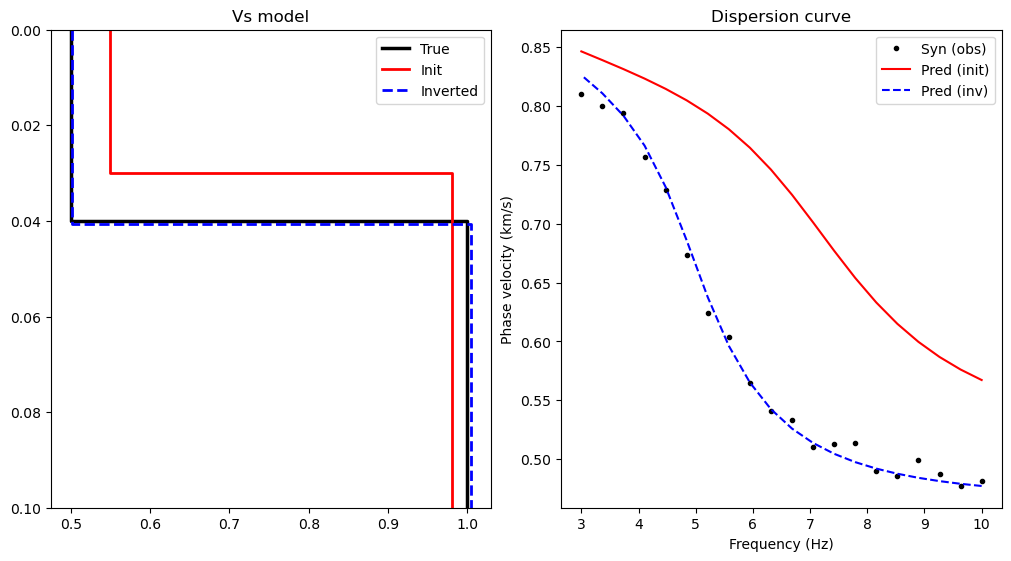

In [22]:
# -----------------------------
# Initial guess (example)
# parameters = [thk(n-1), vs(n)]
# -----------------------------
mode = 0

thk0 = np.array([0.03])     # km (initial thickness of layer 1)
vs0  = np.array([0.55, 0.98])# km/s (initial Vs for 2 layers)
n_layers = len(vs0)

x0 = np.r_[thk0, vs0]

res, model_inv = invert_dispersion_ls(
    observed_periods=syn_period,
    observed_velocity=syn_velocity,
    mode=mode,
    x0=x0,
    n_layers=n_layers,
    method="trf",     # change to "lm" if you want (no bounds)
    verbose=1
)

print("\n=== Inversion result ===")
print("success:", res.success)
print("message:", res.message)
print("x0     :", x0)
print("x_inv  :", res.x)
print("\nInverted model [thk vp vs rho]:\n", model_inv)


# Convert parameter vectors to thickness/vs for plotting
thk_init, vs_init = params2_thk_vs(x0)
thk_inv,  vs_inv  = params2_thk_vs(res.x)

fig, axes = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout=True)

# (1) Vs-depth model comparison
ax0 = axes[0]
depthplot(thk_true, vs_true, ax=ax0, plot_args={"color": "k", "linewidth": 2.5, "linestyle": "-"})
depthplot(thk_init, vs_init, ax=ax0, plot_args={"color": "r", "linewidth": 2.0, "linestyle": "-"})
depthplot(thk_inv,  vs_inv,  ax=ax0, plot_args={"color": "b", "linewidth": 2.0, "linestyle": "--"})
ax0.set_title("Vs model")
ax0.set_ylim(0.1, 0.0)
ax0.legend(["True", "Init", "Inverted"], loc="best")

# (2) Dispersion curve comparison
pred_init = forward_disp(x0,    syn_period, mode=mode)
pred_inv  = forward_disp(res.x, syn_period, mode=mode)

ax1 = axes[1]
ax1.plot(1.0 / syn_period, syn_velocity, "k.", label="Obs (syn + noise)")
ax1.plot(1.0 / syn_period, pred_init,    "r-", label="Pred (init)")
ax1.plot(1.0 / syn_period, pred_inv,     "b--", label="Pred (inv)")
ax1.set_title("Dispersion curve")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Phase velocity (km/s)")
ax1.legend(loc="best")

plt.savefig("ls_inversion_result.png", dpi=150)
plt.show()